In [53]:
from langgraph.graph import StateGraph, START, END
import random
from typing import Dict, List, TypedDict, Optional

In [54]:
class GameState(TypedDict, total=False):
    player_name: str
    guesses: List[int]
    attempts: int
    lower_bound: int
    upper_bound: int
    target: int
    hint: Optional[str]

In [70]:
def setup(state: GameState) -> GameState:
    state["attempts"] = 0
    state["guesses"] = []
    state["lower_bound"] = 1
    state["upper_bound"] = 100
    state["target"] = random.randint(1, 100)  # hidden number
    return state


def guess(state: GameState) -> GameState:
    # Simple binary search strategy
    g = (state["lower_bound"] + state["upper_bound"]) // 2
    state["guesses"].append(g)
    state["attempts"] += 1

    if g == state["target"]:
        state["hint"] = "correct"
    elif g < state["target"]:
        state["hint"] = "higher"
    else:
        state["hint"] = "lower"
    return state


def hint_node(state: GameState) -> GameState:
    last_guess = state["guesses"][-1]
    if state["hint"] == "higher":
        state["lower_bound"] = last_guess + 1
    elif state["hint"] == "lower":
        state["upper_bound"] = last_guess - 1
    return state

def continue_or_end(state: GameState) -> str:
    if state["hint"] == "correct":
        return "end"
    if state["attempts"] >= 7:
        return "end"
    return "continue"

In [71]:
graph = StateGraph(GameState)

graph.add_node("setup", setup)
graph.add_node("guess", guess)
graph.add_node("hint_node", hint_node)

graph.add_edge(START, "setup")
graph.add_edge("setup", "guess")

graph.add_conditional_edges(
    "guess",
    continue_or_end,
    {
        "continue": "hint_node",
        "end": END,
    },
)

graph.add_edge("hint_node", "guess")

app = graph.compile()

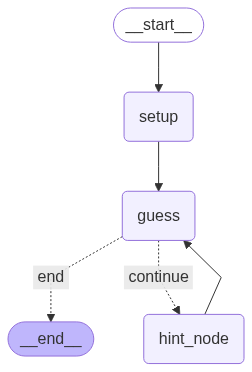

In [72]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [86]:
state = GameState(player_name="Student")
result = app.invoke(state)

print("Target number:", result["target"])
print("Guesses made:", result["guesses"])
print("Attempts:", result["attempts"])
print("Final hint:", result["hint"])


Target number: 46
Guesses made: [50, 25, 37, 43, 46]
Attempts: 5
Final hint: correct
